In [182]:
# source proxypicker-env/bin/activate
# 
# cd /Users/jamaman/Documents/GitHub/ProxyPicker/images
# 
# python3 -m http.server
# 
# image_url = "http://localhost:8000/1.jpg"



In [1]:
import os, getpass
import operator
import base64
import httpx
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from IPython.display import Image
from langgraph.graph import END, StateGraph, START, MessagesState, add_messages
from langchain_core.messages import AnyMessage
from langchain_openai import ChatOpenAI


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
proxy_picker_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2, base_url="https://reverse.onechats.top/v1")

In [3]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "proxy_picker"

In [4]:
object_fetching_prompt = "You are an object fetcher. Please carefully inspect and list all visible physical objects in the image(s) of surrounding objects, ensuring that no object is overlooked."
attribute_extraction_prompt = "You are an attribute extracter. Please describe physical properties of the {target_object} with its position in the given picture labeled in the () in terms of its inertia, interactivity, outline, texture, and hardness"
interaction_parsing_prompt = "You are an interaction parser. Please comprehend the interaction between a VR user and a virtual object in terms of interacted virtual object, contacted part, interaction, and external forces based on the given task: {given_task}, and the given picture of the interacted virtual object"
interaction_classification_prompt = ""
candidate_evaluation_prompt = ""

In [20]:
physical_url = "http://localhost:8000/p1.jpg"
image_data = base64.b64encode(httpx.get(physical_url).content).decode("utf-8")
print(type(image_data))

prefab_url = "http://localhost:8000/f1.jpg"
prefab_data = base64.b64encode(httpx.get(physical_url).content).decode("utf-8")

<class 'str'>


In [6]:
class OverallState(MessagesState):
    given_task: str
    contact: str
    transportability: str
    reconfiguration: str
    score_inertia: int
    score_interaction: int
    score_outline: int
    score_texture: int
    score_hardness: int
    weight_dict: dict
    
    physical_objects: list
    physical_property: Annotated[list, operator.add]
    parsed_interacted_virtual_object: str
    parsed_contacted_part: str
    parsed_interaction: str
    parsed_external_force: str

class PhysicalObjects(BaseModel):
    physical_objects: list[str] = Field(description="The list of physical objects in the given picture with their relative positions e.g. mug(at the top left of the picture, next to a laptop)")
    
class PhysicalProperty(BaseModel):
    inertia: str = Field(description="The physical object's weight or inertia")
    interactivity: str = Field(description="Types of interactions a user could perform with the physical object, such as pressing, rotating, sliding, extending, or any other purposeful manipulation")
    outline: str = Field(description="The shape and size of the physical object as well as its subparts")
    texture: str = Field(description="The surface texture of the physical object as well as its subparts")
    hardness: str = Field(description="The material stiffness of the physical object as well as its subparts")
    
class InteractionParsing(BaseModel):
    interacted_virtual_object: str = Field(description="Identify what virtual object the user will grasp and/or interact with to perform the given task")
    contacted_part: str = Field(description="Identify which part(s) of the virtual object will be mainly contacted by the user during the task")
    interaction: str = Field(description="Determine how the virtual object will be interacted by the user")
    external_force: str = Field(description="Consider what types of external forces the user might encounter while performing the given task")
    
class AttributeState(OverallState):
    target_object: str


In [87]:
def weight_calculator (state: OverallState):
    attributes = ["inertia", "interactivity", "outline", "texture", "hardness"]
    ratings = [state["score_inertia"], state["score_interaction"], state["score_outline"], state["score_texture"], state["score_hardness"]]
    weights = [rating / sum(ratings) for rating in ratings]
    
    weighted_attributes = dict(zip(attributes, weights))
    return {"weight_dict": weighted_attributes}

def object_fetcher (state: OverallState):
    prompt_system = SystemMessage(content=[object_fetching_prompt])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(PhysicalObjects).invoke(messages)
    return {"physical_objects": response.physical_objects, "messages": add_messages(messages, response.physical_objects)} #messages should also be a list : "messages": [response]

def continue_to_attrbute(state: OverallState):
    return [Send("attribute_extracter", {"target_object": t}) for t in state["physical_objects"]]

def attribute_extracter (state: AttributeState):
    prompt = HumanMessage(content=[
        {
            "type": "text",
            "text": attribute_extraction_prompt.format(target_object=state["target_object"]),
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        }
    ])
    response = proxy_picker_llm.with_structured_output(PhysicalProperty).invoke([prompt])
    return {"physical_property": [response]}

def interaction_parser (state: OverallState):
    prompt = HumanMessage(content=[
        {
            "type": "text",
            "text": interaction_parsing_prompt.format(given_task=state["given_task"]),
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{prefab_data}"},
        }
    ])
    response = proxy_picker_llm.with_structured_output(InteractionParsing).invoke([prompt])
    return {"parsed_interacted_virtual_object": response.interacted_virtual_object, "parsed_contacted_part": response.contacted_part, "parsed_interaction": response.interaction, "parsed_external_force": response.external_force}

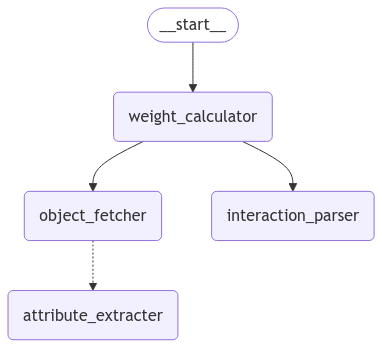

In [88]:
graph = StateGraph(OverallState)
graph.add_node("weight_calculator", weight_calculator)
graph.add_node("object_fetcher", object_fetcher)
graph.add_node("attribute_extracter", attribute_extracter)
graph.add_node("interaction_parser", interaction_parser)

graph.add_edge(START, "weight_calculator")
graph.add_edge("weight_calculator", "object_fetcher")
graph.add_edge("weight_calculator", "interaction_parser")
graph.add_conditional_edges("object_fetcher", continue_to_attrbute, ["attribute_extracter"])
# graph.add_edge("attribute_extracter", END)

proxy_picker = graph.compile()
Image(proxy_picker.get_graph().draw_mermaid_png())

{'weight_calculator': {'weight_dict': {'inertia': 0.23076923076923078, 'interactivity': 0.0, 'outline': 0.38461538461538464, 'texture': 0.23076923076923078, 'hardness': 0.15384615384615385}}}
{'interaction_parser': {'parsed_interacted_virtual_object': 'binoculars', 'parsed_contacted_part': 'eyes', 'parsed_interaction': 'scrutinise', 'parsed_external_force': 'gravity, hand movement'}}
{'object_fetcher': {'physical_objects': ['headphones (top left)', 'fitness tracker (next to headphones)', 'computer mouse (middle left)', 'charging cable (next to mouse)', 'coffee mug (top right)', 'face mask (middle left)', 'remote control (middle)', 'red guitar pick (below remote)', 'nail clipper (below remote)', 'duck-shaped lamp (bottom right)', 'sticky note (bottom left)', 'game controller (bottom middle)', 'scissors (bottom right)', 'pen (bottom left)', 'crumpled paper (bottom middle)', 'black folder (bottom right)'], 'messages': [SystemMessage(content=['You are an object fetcher. Please carefully in
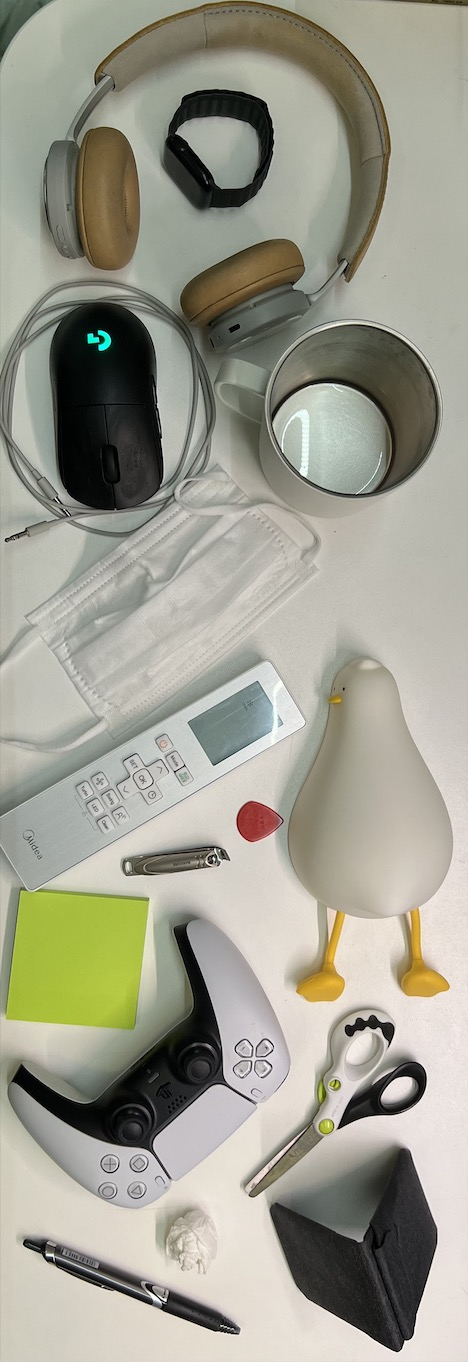

In [89]:
for s in proxy_picker.stream({"given_task": "scrutinise using binoculars", "involvement": "grasp", "transportability": "stationary", "reconfiguration": "rigid", "score_inertia": 3, "score_interaction": 0, "score_outline": 5, "score_texture": 3, "score_hardness": 2}):
    print(s)